In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Patch
from matplotlib.collections import PatchCollection
import matplotlib.font_manager as font_manager

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 7.30.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 52cf609a5544f1bd8bba1ddee4a086289626352c

watermark : 2.2.0
numpy     : 1.21.5
matplotlib: 3.5.1
pandas    : 1.3.5



## Load the dataset


In [3]:
data = pd.read_excel(
    "https://github.com/DataForScience/Viz4Sci/raw/master/data/Nightingale.xlsx"
)

In [4]:
data.describe()

,Year,Monthly Death Total,Annual Mortality Rate (per 1000 soldiers)
count,72.00000,72.000000,72.000000
mean,1854.75000,250.027778,90.895833
std,0.66608,484.726610,183.081991
min,1854.00000,0.000000,0.000000
25%,1854.00000,19.750000,6.500000
50%,1855.00000,54.000000,17.250000
75%,1855.00000,225.750000,68.800000
max,1856.00000,2761.000000,1022.800000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Month                                      72 non-null     object 
 1   Year                                       72 non-null     int64  
 2   Cause of Death                             72 non-null     object 
 3   Monthly Death Total                        72 non-null     int64  
 4   Annual Mortality Rate (per 1000 soldiers)  72 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.9+ KB


In [6]:
data.head()

,Month,Year,Cause of Death,Monthly Death Total,Annual Mortality Rate (per 1000 soldiers)
0,April,1854,Infectious Disease,1,1.4
1,May,1854,Infectious Disease,12,6.2
2,June,1854,Infectious Disease,11,4.7
3,July,1854,Infectious Disease,359,150.0
4,August,1854,Infectious Disease,828,328.5


Combine month and year into a single column



In [7]:
data["date"] = data[["Month", "Year"]].apply(
    lambda x: x["Month"] + " " + str(x["Year"]), axis=1
)

In [9]:
del data["Month"]

In [10]:
del data["Year"]

Pivot data into a table with each cause of death as a column. We're keeping only the mortality rate.

In [11]:
infectious = pd.pivot_table(
    data,
    index="date",
    columns="Cause of Death",
    values="Annual Mortality Rate (per 1000 soldiers)",
    aggfunc="sum",
)

In [12]:
infectious

Cause of Death,All Other Causes,Infectious Disease,Wounds and Injuries
date,,,
April 1854,7.0,1.4,0.0
April 1855,21.2,177.5,17.9
August 1854,11.9,328.5,0.4
August 1855,6.7,129.9,44.1
December 1854,48.0,631.5,41.7
December 1855,7.8,25.3,5.0
February 1855,140.1,822.8,16.3
February 1856,5.2,6.6,0.0
January 1855,120.0,1022.8,30.7


Put the columns in the right order

In [13]:
infectious = infectious[
    [
        "Wounds and Injuries",
        "All Other Causes",
        "Infectious Disease",
    ]
]

Normalize values

In [14]:
infectious = (infectious**2).cumsum(axis=1)
infectious /= infectious.max().max()
infectious = np.sqrt(infectious)

Subset and order the rows

In [15]:
order = [
    "April 1854",
    "May 1854",
    "June 1854",
    "July 1854",
    "August 1854",
    "September 1854",
    "October 1854",
    "November 1854",
    "December 1854",
    "January 1855",
    "February 1855",
    "March 1855",
]

infectious = infectious.loc[order].reset_index()
infectious = infectious[::-1]

Color list

In [16]:
colors = [
    "#51a7f9",
    "black",
    "#f9517b",
]

Generate the figure

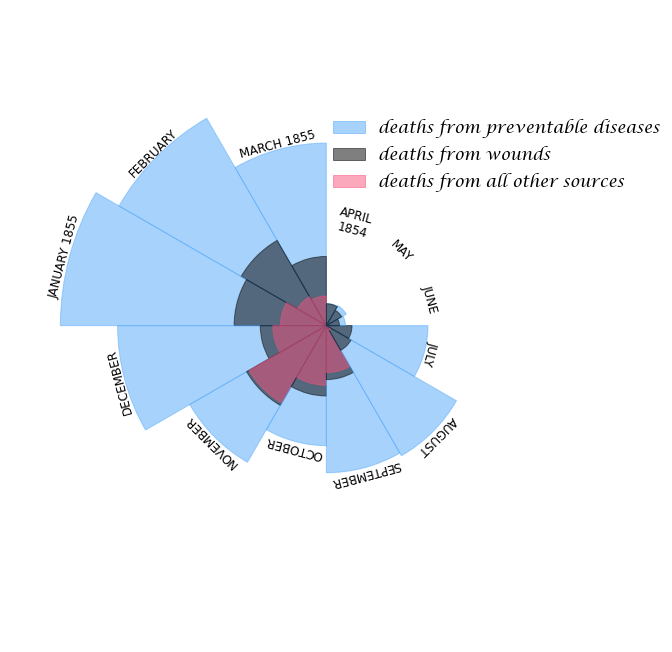

In [21]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_aspect(1.0)

patches = []
color = []
total = 90  # First wedge starts off at 90'
angle = 30  # Each wedge covers 30'

for i in range(infectious.shape[0])[::1]:
    for j, col in enumerate(
        [
            "Infectious Disease",
            "All Other Causes",
            "Wounds and Injuries",
        ]
    ):
        value = infectious[col].iloc[i]
        patches.append(Wedge((0, 0), np.sqrt(value), total, total + angle))
        color.append(colors[j])

    length = np.max([np.sqrt(infectious.iloc[i, 1:4].max()) + 0.02, 0.4])
    x = length * np.cos((total + angle / 2) * np.pi / 180)
    y = length * np.sin((total + angle / 2) * np.pi / 180)

    label = infectious["date"].iloc[i]

    if label[:3] not in ["Mar", "Jan", "Apr"]:
        label = label.split()[0]
    elif label[:3] == "Apr":
        label = "\n".join(label.split())

    ax.text(
        x,
        y,
        label.upper(),
        rotation=(total + angle / 2 - 90),
        ha="center",
        va="center",
        fontsize=12,
    )

    total += angle

p = PatchCollection(patches, color=color, alpha=0.5)
ax.add_collection(p)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

patches = []
legend = [
    "deaths from preventable diseases",
    "deaths from wounds",
    "deaths from all other sources",
]

# you'll need to change the font location
font = font_manager.FontProperties(
    fname="Lucida Calligraphy Italic.ttf", weight="normal", style="italic", size=16
)

for i, leg in enumerate(legend):
    patches.append(Patch(color=colors[i], label=leg, alpha=0.5))

ax.legend(handles=patches, loc=(0.5, 0.7), fancybox=False, frameon=False, prop=font)

ax.axis("off")
fig.tight_layout()